In [9]:
import numpy as np
import sys
from os.path import expanduser
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.wcs import WCS

## Relative folder

In [8]:
home = expanduser("~")
datafolder=home+'/astro/AstronomyTutorials/data/'
print(datafolder)

/home/astromix/astro/AstronomyTutorials/data/


## Open fits file

In [11]:
mrk79_file='COcube.fits'
mrk79_fits=fits.open(datafolder+mrk79_file)[0]

## Fits header

In [17]:
mrk79_header=mrk79_fits.header
mrk79_header
#display(mrk79_header) #display is a notebook type printing system, doesn't work in a script (it is the same as just writing the above)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   97                                                  
NAXIS2  =                   97                                                  
NAXIS3  =                  190                                                  
NAXIS4  =                    1                                                  
DATAMIN = -0.6655395496637E-02         /                                        
DATAMAX =  0.2891516312957E-01         /                                        
BUNIT   = 'Jy/beam     '               /                                        
CTYPE1  = 'RA---ARC    '               /                                        
CRVAL1  =  0.1156366666667E+03         /                                        
CDELT1  = -0.1731111137690E-

## Data

In [22]:
mrk79_data=mrk79_fits.data
print(f'Shape of data is {mrk79_data.shape}, so this is not a cube, it has an extra dimension without a reason')
mrk79_data=mrk79_data[0]
print(f'Shape of data is {mrk79_data.shape}, seems fine, the dimensions is (z,y,x) (there is a (computation speed) reason for this, so it is better to keep this structure)')

Shape of data is (1, 190, 97, 97), so this is not a cube, it has an extra dimension without a reason
Shape of data is (190, 97, 97), seems fine, the dimensions is (z,y,x) (there is a (computation speed) reason for this, so it is better to keep this structure)


### Calculate the coordinates
From the header the z coordinate has velocity dimensions ```CTYPE3  = 'VRAD'``` in km/s ```CUNIT3  = 'km/s'```

From the header the x,y coordinates has RA/DEC dimensions ```CTYPE1  = 'RA---ARC'```,```CTYPE2  = 'DEC--ARC'``` in degrees```CUNIT1  = 'deg'```

In [73]:
dx

-0.6232000095683999

In [74]:
-mrk79_data.shape[2]*dx/2.

30.225200464067395

In [126]:
dx = np.abs(mrk79_header['CDELT1'])*3600 #arcsec
dy = np.abs(mrk79_header['CDELT2'])*3600 #arcsec
dv = mrk79_header['CDELT3'] #km/s

xx=np.linspace(-mrk79_data.shape[2]*dx/2.,mrk79_data.shape[2]*dx/2.,mrk79_header['NAXIS1']) #arcsec
yy=np.linspace(-mrk79_data.shape[1]*dx/2.,mrk79_data.shape[1]*dx/2.,mrk79_header['NAXIS2']) #arcsec

b=mrk79_header['CRVAL3']-mrk79_header['CRPIX3']*dv #zero point velocity
vv=np.linspace(b+dv,b+dv*mrk79_header['NAXIS3'],mrk79_header['NAXIS3'])

### Make some plots

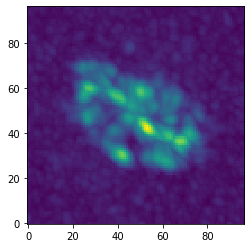

In [127]:
mrk79_max = np.nanmax(mrk79_data,axis=0) #collpase the cube along 0 dimension (velocity) by keeping only the maximum velocities 
plt.imshow(mrk79_max,origin='low') # Image plot, dimensions are pixels

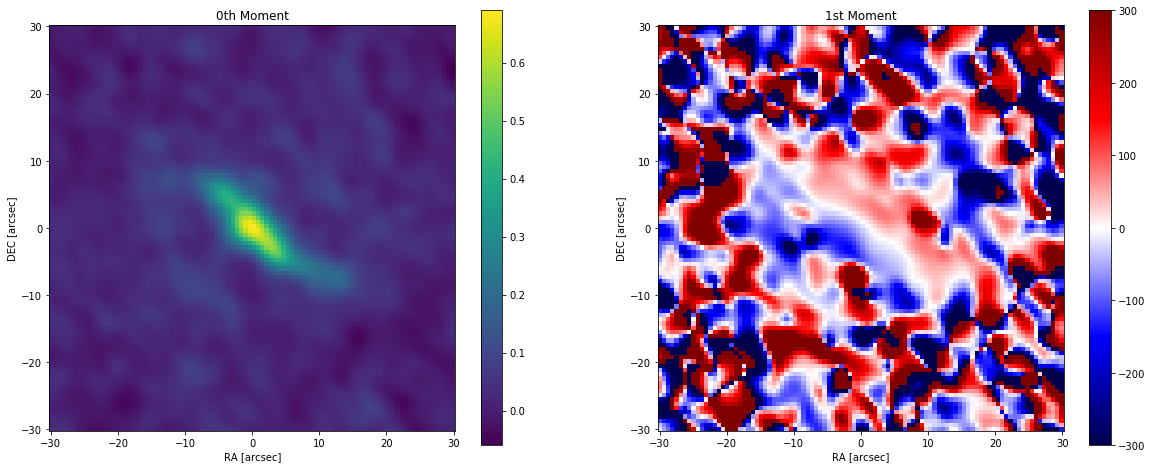

In [128]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
mrk79_mom0 = np.nansum(mrk79_data,axis=0) #collapse the cube along 0 dimension (velocity) by summing (zeroth moment)
mrk79_mom1=np.nansum(vv[:,None,None]*mrk79_data,axis=0)/mrk79_mom0 #first moment
p0=axes[0].pcolormesh(xx,yy,mrk79_mom0)
axes[0].set(aspect=1,xlabel='RA [arcsec]',ylabel='DEC [arcsec]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])

p1=axes[1].pcolormesh(xx,yy,mrk79_mom1,vmin=-300,vmax=300,cmap='seismic')
axes[1].set(aspect=1,xlabel='RA [arcsec]',ylabel='DEC [arcsec]',title='1st Moment')
fig.colorbar(p1, ax=axes[1])

### Extra: Calculate the intrinsic dimensions

<Quantity 0.45056033 kpc / arcsec>

<Quantity 97.12517518 Mpc>

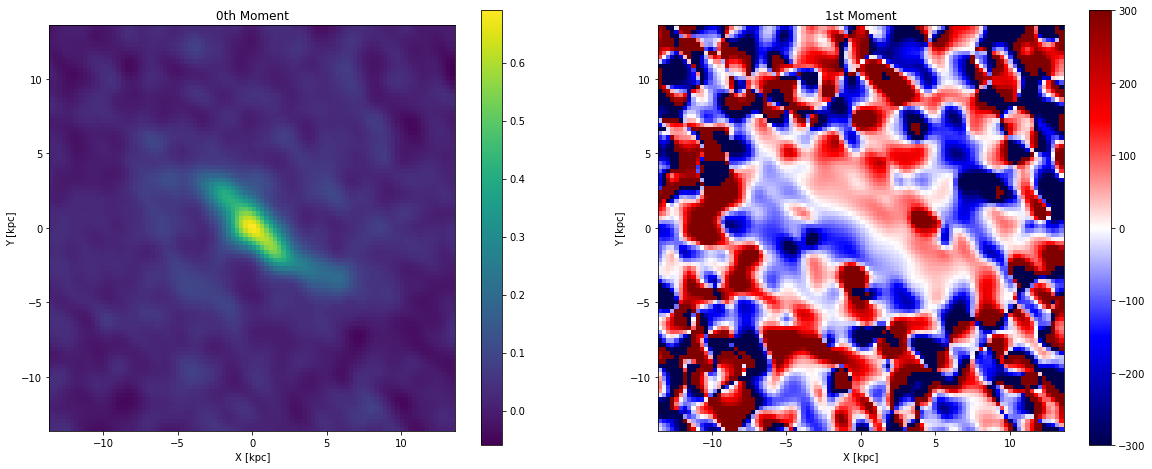

In [129]:
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3,Ode0=0.7) #create a cosmology
z=0.022296 #redshit
D=cosmo.luminosity_distance(z) #distance to the object
arctokpc = (cosmo.angular_diameter_distance(z=z)/206265).to(u.kpc)/u.arcsec
display(arctokpc)
ak=arctokpc.value
display(D)

xx_kpc=xx*ak
yy_kpc=yy*ak

fig, axes = plt.subplots(1,2,figsize=(20,8))
mrk79_mom0 = np.nansum(mrk79_data,axis=0) #collapse the cube along 0 dimension (velocity) by summing (zeroth moment)
mrk79_mom1=np.nansum(vv[:,None,None]*mrk79_data,axis=0)/mrk79_mom0 #first moment
p0=axes[0].pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)
axes[0].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])

p1=axes[1].pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-300,vmax=300,cmap='seismic')
axes[1].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')
fig.colorbar(p1, ax=axes[1])

## Position Velocity Plots

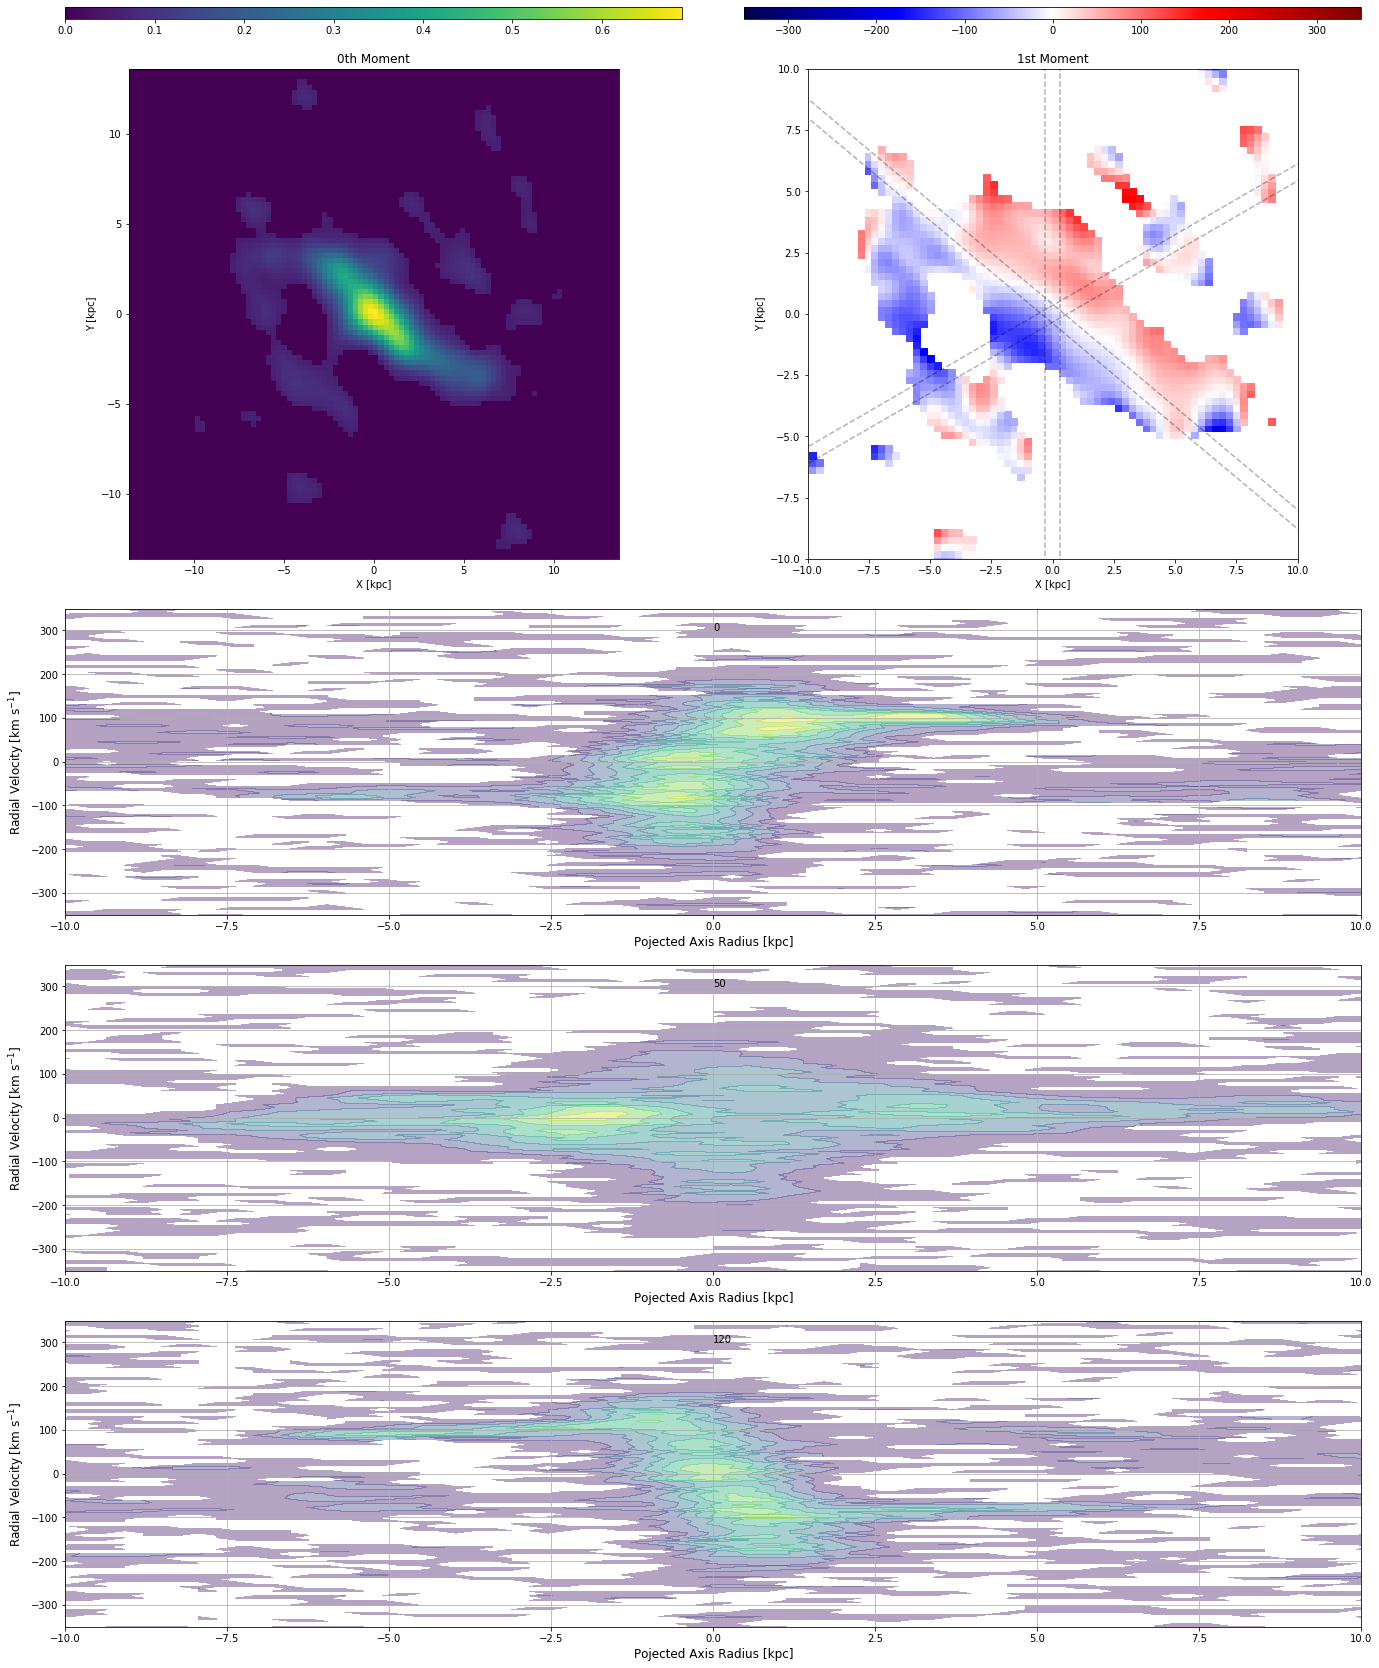

In [142]:
import matplotlib.gridspec as gridspec

papvds = [0,50,120]
slit=0.6 #slit width in kpc

limy=[-10,10]
limv=[-350,350]

Nplots=len(papvds)
Ncubes = 1
fig = plt.figure(figsize=(20,10+5*Nplots))
gs=gridspec.GridSpec(2+Nplots, 2*Ncubes, height_ratios=[0.02,0.8]+[0.5]*Nplots, width_ratios=[0.8,0.8]*Ncubes)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ipx=0
axmom0 = fig.add_subplot(gs[1,ipx])
caxmom0 = fig.add_subplot(gs[0,ipx])
ipx=ipx+1
axmom1 = fig.add_subplot(gs[1,ipx])
caxmom1 = fig.add_subplot(gs[0,ipx])

cm0=axmom0.pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)#,vmin=np.nanmin(mom0p),vmax=np.nanmax(mom0p))
plt.colorbar(cm0,cax=caxmom0,orientation='horizontal').ax.tick_params(labelsize=10)
axmom0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')  

cm1=axmom1.pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-350,vmax=350,cmap='seismic')
plt.colorbar(cm1,cax=caxmom1,orientation='horizontal').ax.tick_params(labelsize=10)  
axmom1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')   

dx_kpc=(dx)*ak #dx in kpc
ithick = int(round(slit/dx_kpc)) #number of pixels which are going to collapse (inside the slit)
ixc = round(mrk79_data.shape[2]/2) #where is the center in pixels

for j,papvd in enumerate(papvds):
        
    def yslit_low(x): return slit/(2*np.cos(np.radians(papvd+90))) +x*np.tan(np.radians(papvd+90))
    def yslit_high(x): return -slit/(2*np.cos(np.radians(papvd+90))) +x*np.tan(np.radians(papvd+90))
    axmom1.plot(xx_kpc,yslit_low(xx_kpc),'--',alpha=0.3, color='black')
    axmom1.plot(xx_kpc,yslit_high(xx_kpc),'--',alpha=0.3, color='black')
    axmom1.set(xlim=[-10,10],ylim=[-10,10])   

    axpvd = fig.add_subplot(gs[2+j,:])
    axpvd.text(x=np.mean(limy),y=300,s="{}".format(papvd))
    axpvd.set_xlabel('Pojected Axis Radius [kpc]',fontsize=12)
    axpvd.set_ylabel(r'Radial Velocity [km s$^{-1}$]',fontsize=12)
#     axpvd.xaxis.set_ticks(np.arange(-5,5.5,1))
#     axpvd.yaxis.set_ticks(np.arange(-400,400,50))
    axpvd.set_xlim(limy)
    axpvd.set_ylim(limv)
    axpvd.grid(True)

    # cube0 = np.where(np.isfinite(cube1m),cube1m,0)
    cube0 = np.where(np.isfinite(mrk79_data),mrk79_data,0) #replace nans with 0
    rotcube=ndimage.interpolation.rotate(cube0, papvd, axes=(1, 2), reshape=False) #rotate the cube along 0 dimension
    pvd_cube = np.nansum(rotcube[:,:,ixc-ithick:ixc+ithick],axis=2) #collapse the slit by summing

    pvd_cube=np.where(pvd_cube>=0,pvd_cube,np.nan) 
    ppvd_res=axpvd.contourf(yy_kpc,vv,pvd_cube,alpha=0.4)

### Extra: make a mask

In [132]:
nosignalregions={'1':{'x0':-10,'dx':5,'y0':-10,'dy':5},
                 '2':{'x0':7,'dx':5,'y0':7,'dy':5}}
sigma=3

Region 1 std noise 0.01704
Region 2 std noise 0.02036
Mean std noise 0.01870


[Text(0, 0.5, 'Y [kpc]'),
 Text(0.5, 0, 'X [kpc]'),
 Text(0.5, 1.0, 'Mask'),
 None]

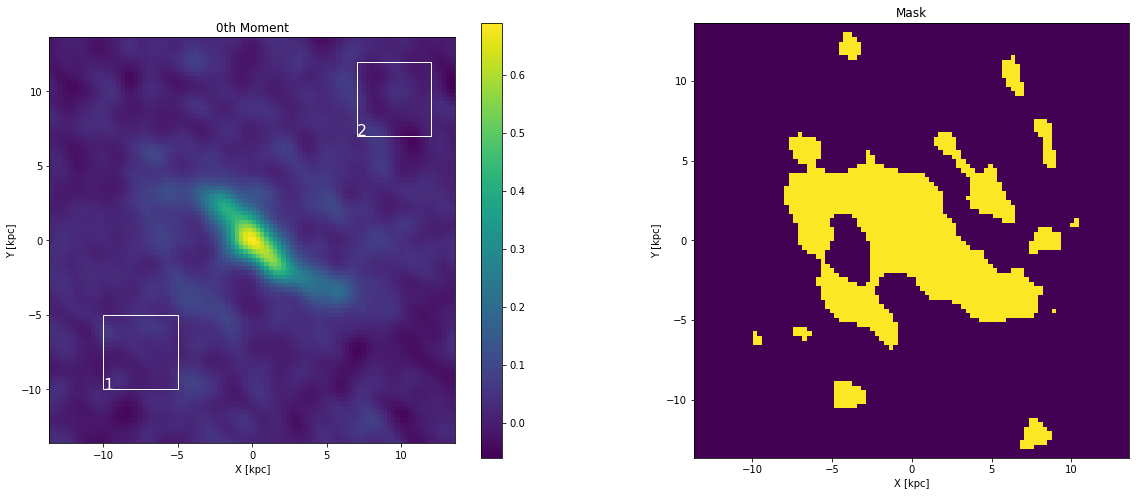

In [137]:
import matplotlib.patches as patches
fig, axes = plt.subplots(1,2,figsize=(20,8))
mrk79_mom0 = np.nansum(mrk79_data,axis=0) #collapse the cube along 0 dimension (velocity) by summing (zeroth moment)

p0=axes[0].pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)
axes[0].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])
noises=np.array([])
for reg in nosignalregions:
    x0_reg=nosignalregions[reg]['x0']
    y0_reg=nosignalregions[reg]['y0']
    dx_reg=nosignalregions[reg]['dx']
    dy_reg=nosignalregions[reg]['dy']
    rect = patches.Rectangle((x0_reg,y0_reg),dx_reg,dy_reg,linewidth=1,edgecolor='w',facecolor='none')
    axes[0].add_patch(rect)
    axes[0].text(x0_reg,y0_reg,reg,color='w',fontsize=16)
    noise=np.nanstd(mrk79_mom0[np.ix_((xx_kpc>x0_reg)&(xx_kpc<x0_reg+dx_reg),(yy_kpc>y0_reg)&(yy_kpc<y0_reg+dy_reg))])
    noises=np.append(noises,noise)
    print(f'Region {reg} std noise {noise:.5f}')
mean_noise=np.nanmean(noises)
print(f'Mean std noise {mean_noise:.5f}')
mask=np.where(mrk79_mom0>sigma*mean_noise,True,False)
axes[1].pcolormesh(xx_kpc,yy_kpc,mask)
axes[1].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Mask')


In [138]:
mrk79_data_masked=np.where(mask[None,:,:],mrk79_data,np.nan)
mrk79_mom0 = np.nansum(mrk79_data_masked,axis=0) 
mrk79_mom1=np.nansum(vv[:,None,None]*mrk79_data_masked,axis=0)/mrk79_mom0 #first moment

/home/astromix/miniconda3/envs/ARCenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
dx_kpc

0.28078920181783623

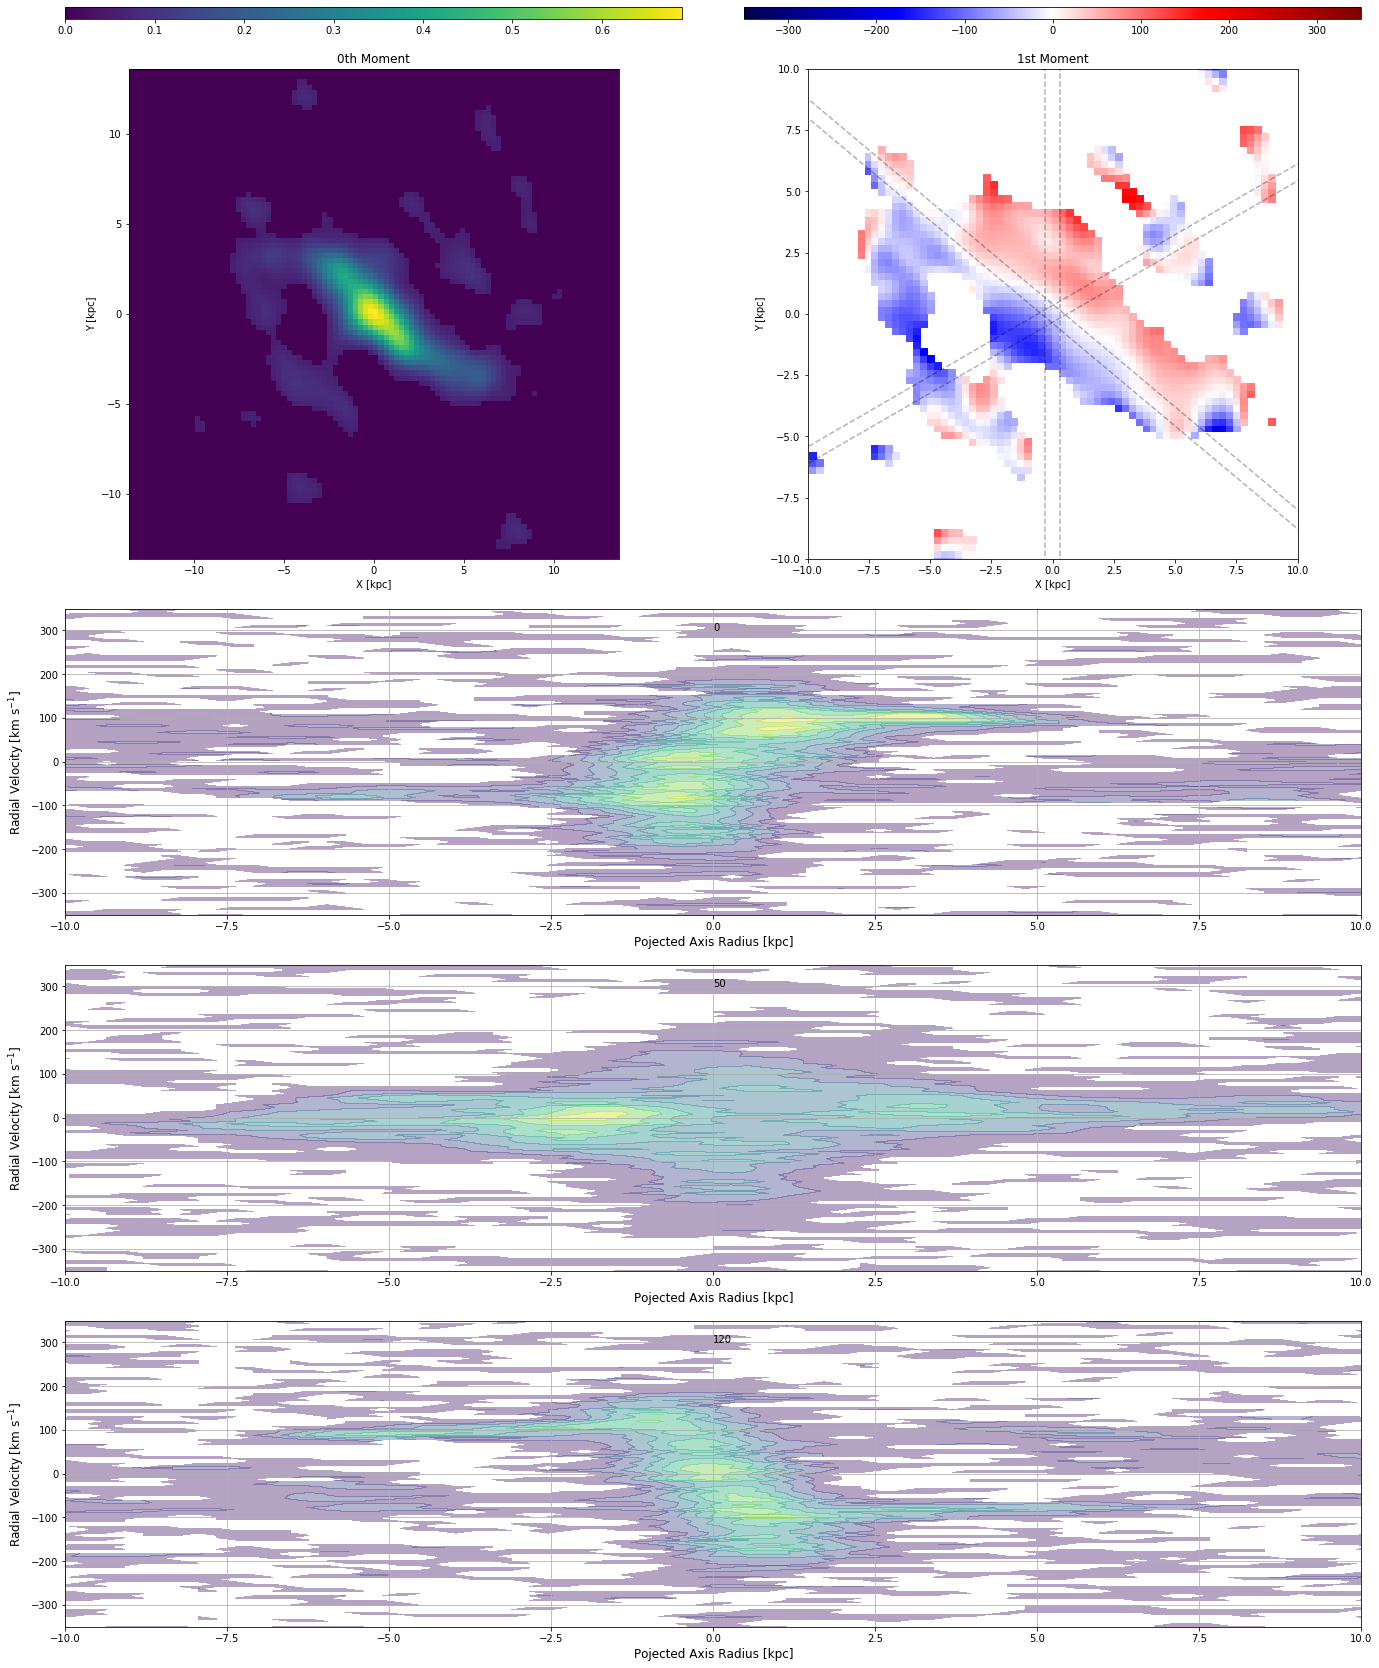

In [141]:
import matplotlib.gridspec as gridspec

papvds = [0,50,120]
slit=0.6 #slit width in kpc

limy=[-10,10]
limv=[-350,350]

Nplots=len(papvds)
Ncubes = 1
fig = plt.figure(figsize=(20,10+5*Nplots))
gs=gridspec.GridSpec(2+Nplots, 2*Ncubes, height_ratios=[0.02,0.8]+[0.5]*Nplots, width_ratios=[0.8,0.8]*Ncubes)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ipx=0
axmom0 = fig.add_subplot(gs[1,ipx])
caxmom0 = fig.add_subplot(gs[0,ipx])
ipx=ipx+1
axmom1 = fig.add_subplot(gs[1,ipx])
caxmom1 = fig.add_subplot(gs[0,ipx])


cm0=axmom0.pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)#,vmin=np.nanmin(mom0p),vmax=np.nanmax(mom0p))
plt.colorbar(cm0,cax=caxmom0,orientation='horizontal').ax.tick_params(labelsize=10)
axmom0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')  

cm1=axmom1.pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-350,vmax=350,cmap='seismic')
plt.colorbar(cm1,cax=caxmom1,orientation='horizontal').ax.tick_params(labelsize=10)  
axmom1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')   

dx_kpc=(dx)*ak #dx in kpc
ithick = int(round(slit/dx_kpc)) #number of pixels which are going to collapse (inside the slit)
ixc = round(mrk79_data.shape[2]/2) #where is the center in pixels

for j,papvd in enumerate(papvds):
        
    def yslit_low(x): return slit/(2*np.cos(np.radians(papvd+90))) +x*np.tan(np.radians(papvd+90))
    def yslit_high(x): return -slit/(2*np.cos(np.radians(papvd+90))) +x*np.tan(np.radians(papvd+90))
    axmom1.plot(xx_kpc,yslit_low(xx_kpc),'--',alpha=0.3, color='black')
    axmom1.plot(xx_kpc,yslit_high(xx_kpc),'--',alpha=0.3, color='black')
    axmom1.set(xlim=[-10,10],ylim=[-10,10])   

    axpvd = fig.add_subplot(gs[2+j,:])
    axpvd.text(x=np.mean(limy),y=300,s="{}".format(papvd))
    axpvd.set_xlabel('Pojected Axis Radius [kpc]',fontsize=12)
    axpvd.set_ylabel(r'Radial Velocity [km s$^{-1}$]',fontsize=12)
#     axpvd.xaxis.set_ticks(np.arange(-5,5.5,1))
#     axpvd.yaxis.set_ticks(np.arange(-400,400,50))
    axpvd.set_xlim(limy)
    axpvd.set_ylim(limv)
    axpvd.grid(True)

    # cube0 = np.where(np.isfinite(cube1m),cube1m,0)
    cube0 = np.where(np.isfinite(mrk79_data),mrk79_data,0) #replace nans with 0
    rotcube=ndimage.interpolation.rotate(cube0, papvd, axes=(1, 2), reshape=False) #rotate the cube along 0 dimension
    pvd_cube = np.nansum(rotcube[:,:,ixc-ithick:ixc+ithick],axis=2) #collapse the slit by summing

    pvd_cube=np.where(pvd_cube>=0,pvd_cube,np.nan) 
    ppvd_res=axpvd.contourf(yy_kpc,vv,pvd_cube,alpha=0.4)